<a href="https://colab.research.google.com/github/jbsher/capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brody Sherwood

## Capstone: Hagrid Hand Gesture Recognition

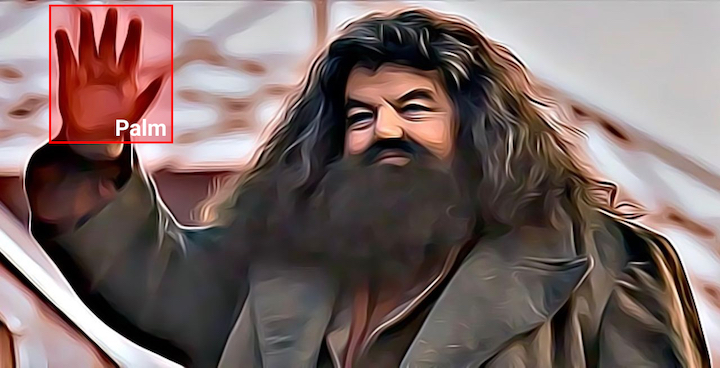

Imports

In [1]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import torchvision.transforms as transforms
import seaborn as sns
import pickle
import plotly.figure_factory as ff
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from collections import defaultdict
import plotly.figure_factory as ff

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Read in**

Note: This dataset is a subset of 1000 images per category that I took from a larger dataset.

In [3]:
class_names = [
   'call',
   'dislike',
   'fist',
   'four',
   'like',
   'mute',
   'ok',
   'one',
   'palm',
   'peace_inverted',
   'peace',
   'rock',
   'stop_inverted',
   'stop',
   'three',
   'three2',
   'two_up',
   'two_up_inverted']

formats = (".jpeg", ".jpg", ".jp2", ".png", ".tiff", ".jfif", ".bmp", ".webp", ".heic")

# Paths to data
path_to_train = "/content/drive/MyDrive/capstone/data/train_val"
path_to_test = "/content/drive/MyDrive/capstone/data/test_"


**Preprocessor and import functions.**

In [4]:
# Preprocesser function
def preprocess_image(img):
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (512, 512))

    # Convert datatype and normalize the pixel values to [-1, 1]
    img = img.astype('float32')
    img = (img / 255.0 - 0.5) * 2

    return img

In [5]:
def load_data_by_category(path_to_data):
    data_by_category = {}

    # Iterate over all the class names
    for label, class_name in enumerate(class_names):
        # Path to the class-specific folder
        class_folder_path = os.path.join(path_to_data, class_name)

        category_data = []

        # Iterate over every file in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.endswith(formats):
                filepath = os.path.join(class_folder_path, filename)

                # Load and preprocess the image
                img = cv2.imread(filepath)
                img = preprocess_image(img)

                # Append the preprocessed image and its label to category_data
                category_data.append((img, label))

        data_by_category[class_name] = category_data

    return data_by_category


In [6]:
# Create a new Sequence class
class HagridGestureDataset(Sequence):
    def __init__(self, input_data=None, batch_size=32, shuffle=True):
        self.data = input_data if input_data else []
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        X = []
        y = []

        for idx in batch_indexes:
            img, label = self.data[idx]
            X.append(img)
            y.append(label)

        X = np.array(X)
        y = np.array(y)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

---
SAVE DATA

---

*Train*

In [ ]:
# Load train data by category
train_by_category = load_data_by_category(path_to_train)

# Save each category's train data to its separate file
for category, data in train_by_category.items():
    category_dataset = HagridGestureDataset(input_data=data, shuffle=False)
    with open(f'/content/drive/MyDrive/capstone/data/train_{category}.pkl', 'wb') as f:
        pickle.dump(category_dataset.data, f)


*Test*

In [ ]:
test_dataset = HagridGestureDataset(input_data=load_data_from_path(path_to_test), shuffle=False)

with open('/content/drive/MyDrive/capstone/data/test.pkl', 'wb') as f:
    pickle.dump(test_dataset.data, f)


---
LOAD DATA

---

*Train*

In [ ]:
# Load data for a given category
def load_category_data(category_name):
    with open(f'/content/drive/MyDrive/capstone/data/train_{category_name}.pkl', 'rb') as f:
        return pickle.load(f)

# Store data in a dictionary
train_by_category = {}
for category in class_names:
    train_by_category[category] = load_category_data(category)

# Combine the category-wise data to get combined train data
train_data_combined = []
for data in train_by_category.values():
    train_data_combined.extend(data)
train_combined_dataset = HagridGestureDataset(input_data=train_data_combined, shuffle=False)


*Test*

In [ ]:
# To load the test data
with open('/content/drive/MyDrive/capstone/data/test.pkl', 'rb') as f:
    test_data = pickle.load(f)
test_dataset = HagridGestureDataset(input_data=test_data, shuffle=False)


Look at some images from each class

In [ ]:
def show_images(data_by_category, num_each=1):
    for category, data in data_by_category.items():
        shown_labels_count = {i: 0 for i in range(len(class_names))}

        # Increase the height of the figure to make images bigger
        plt.figure(figsize=(40, 25))  # Adjust these numbers as needed to increase the size of the entire figure

        idx = 1

        # Convert data into a temporary dataset to sample from
        tmp_dataset = HagridGestureDataset(input_data=data, shuffle=True)

        # Sample a few batches from this temporary dataset
        for i in range(min(10, len(tmp_dataset))):
            images_batch, labels_batch = tmp_dataset[i]
            for j, image in enumerate(images_batch):
                label = labels_batch[j]

                if shown_labels_count[label] < num_each:
                    # Change the subplot layout to display images in a grid
                    plt.subplot(2, len(class_names), idx)
                    plt.imshow(rescale_image(image))
                    plt.title(class_names[label])
                    plt.axis("off")

                    shown_labels_count[label] += 1
                    idx += 1

            # Check if we've shown the required number for each class
            if all(count >= num_each for count in shown_labels_count.values()):
                break

        plt.tight_layout()
        plt.show()

def rescale_image(image):
    return (image + 1) / 2.0



Statistical Features

In [ ]:
# Specify the path to your dataset
dataset_path = "/content/drive/MyDrive/capstone/data/train_val"

# Initialize dictionaries to store the number of samples in each category and size distribution
samples_per_category = {}
size_distribution = []

# Iterate over categories in the dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        # Count the number of samples in each category
        num_samples = len(os.listdir(category_path))
        samples_per_category[category] = num_samples

        # Collect size information for each image in the category
        for filename in os.listdir(category_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(category_path, filename)
                img = cv2.imread(image_path)
                height, width, _ = img.shape
                size_distribution.append((width, height))

# Plot the size distribution of images
widths, heights = zip(*size_distribution)
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='orange')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Size Distribution of Images")
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines for reference
plt.tight_layout()
plt.show()

print(samples_per_category)


In [30]:
# Get mean rgb values
def get_average_rgb(image):
    # Convert the image from [-1, 1] range to [0, 255] for visualization
    adjusted_image = (image + 1) * 127.5
    return np.mean(adjusted_image, axis=(0, 1))

avg_rgb_by_category = {}

for category, data in train_by_category.items():
    category_avg_rgb = []
    for img, _ in data:
        avg_rgb = get_average_rgb(img)
        category_avg_rgb.append(avg_rgb)
    avg_rgb_by_category[category] = np.mean(category_avg_rgb, axis=0)


In [92]:
def plot_rgb_for_subset(categories_subset, subset_number):
    avg_rgb_subset = [avg_rgb_by_category[cat] for cat in categories_subset]

    # Create table data
    table_data = [['Category', 'Avg Red', 'Avg Green', 'Avg Blue']]
    for cat, rgb in zip(categories_subset, avg_rgb_subset):
        table_data.append([cat, round(rgb[0], 2), round(rgb[1], 2), round(rgb[2], 2)])

    # Create the table figure
    fig = ff.create_table(table_data, height_constant=60)

    # Bar chart data
    avg_red = [round(rgb[0], 2) for rgb in avg_rgb_subset]
    avg_green = [round(rgb[1], 2) for rgb in avg_rgb_subset]
    avg_blue = [round(rgb[2], 2) for rgb in avg_rgb_subset]

    # Create bar chart traces
    trace1 = go.Bar(x=categories_subset, y=avg_red, xaxis='x2', yaxis='y2', marker=dict(color='#AB3640'), name='Avg Red')
    trace2 = go.Bar(x=categories_subset, y=avg_green, xaxis='x2', yaxis='y2', marker=dict(color='#C7D01D'), name='Avg Green')
    trace3 = go.Bar(x=categories_subset, y=avg_blue, xaxis='x2', yaxis='y2', marker=dict(color='#7E7ED8'), name='Avg Blue')

    # Add bar chart traces to the figure
    fig.add_traces([trace1, trace2, trace3])

    # Initialize xaxis2 and yaxis2
    fig['layout']['xaxis2'] = {}
    fig['layout']['yaxis2'] = {}

    # Edit layout for subplots
    fig.layout.yaxis.update({'domain': [0, .45]})
    fig.layout.yaxis2.update({'domain': [.6, 1]})
    fig.layout.yaxis2.update({'anchor': 'x2'})
    fig.layout.xaxis2.update({'anchor': 'y2'})
    fig.layout.yaxis2.update({'title': 'RGB Values'})

    # Update the margins to add a title and see graph x-labels
    fig.layout.margin.update({'t': 75, 'l': 50})
    fig.layout.update({'title': f'Average RGB values for Categories ({subset_number})'})

    # Adjust the height
    fig.layout.update({'height': 800})

    # Display the plot
    fig.show()

# Split the categories into 3 subsets and plot each
all_categories = list(avg_rgb_by_category.keys())
for i in range(0, len(all_categories), 6):
    subset = all_categories[i:i+6]
    plot_rgb_for_subset(subset, f"{i+1}-{i+len(subset)}")


Look at the top values for each color.

In [93]:
# Retrieve the top categories based on average color values
def top_categories_for_color(color_index, n=3):
    sorted_categories = sorted(avg_rgb_by_category.items(),
                               key=lambda x: x[1][color_index],
                               reverse=True)
    return [cat[0] for cat in sorted_categories[:n]]

top_red = top_categories_for_color(0)
top_green = top_categories_for_color(1)
top_blue = top_categories_for_color(2)

unique_top_categories = list(set(top_red + top_green + top_blue))

plot_rgb_for_subset(unique_top_categories, "Top Categories by RGB")

***'two_up'*** has the highest average **Red**, with ***'call'*** having both the highest average **Green** and **Blue.**





Lets look at some sample images and their color characteristics.

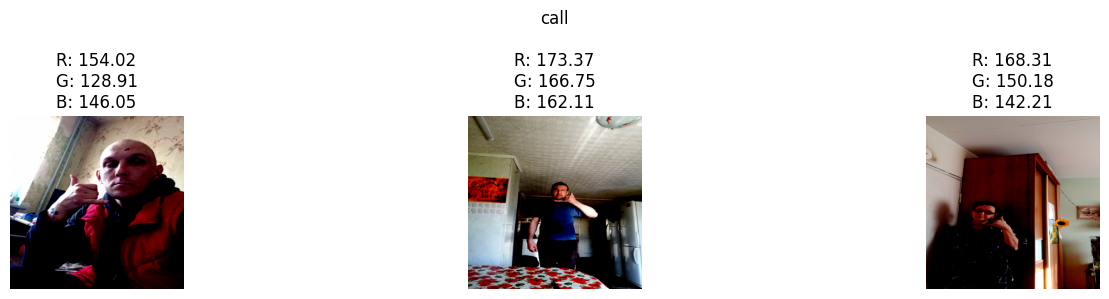

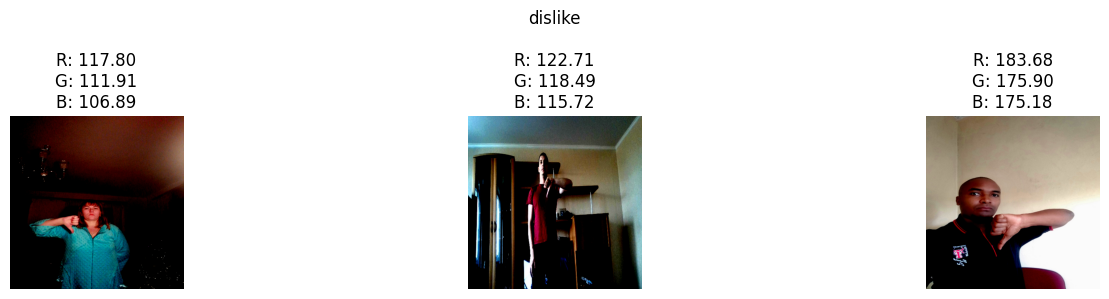

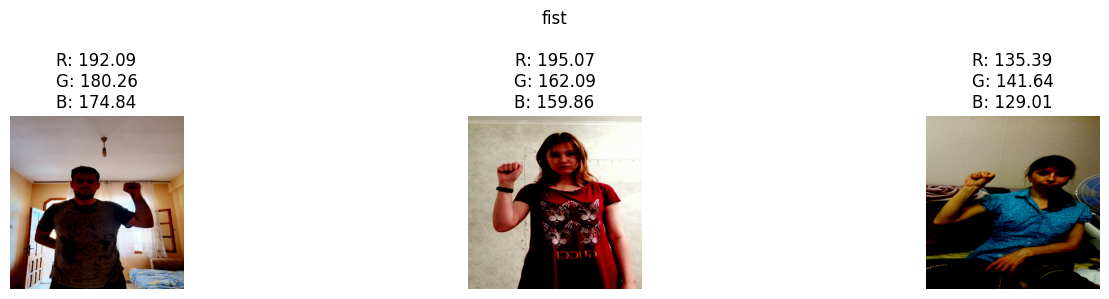

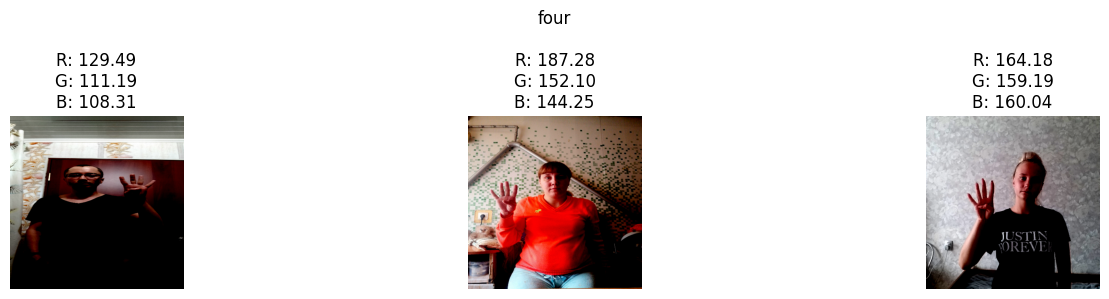

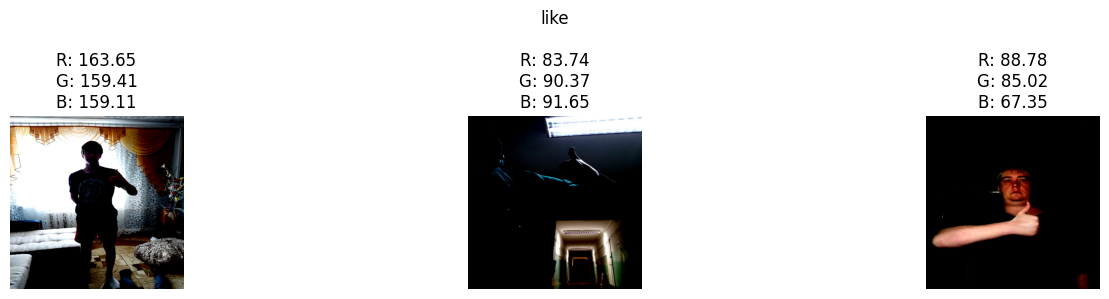

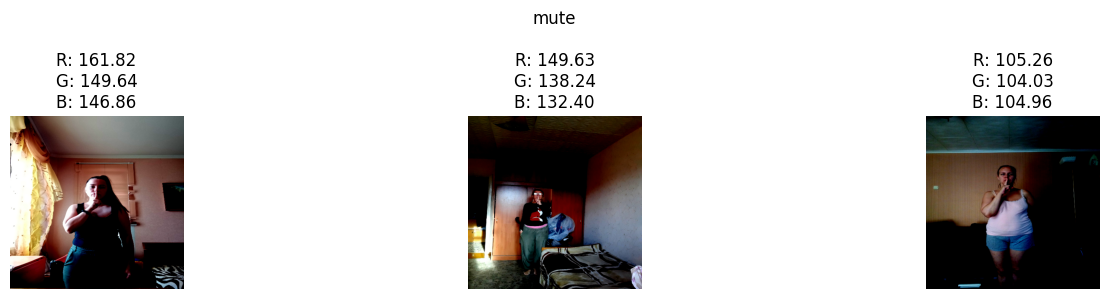

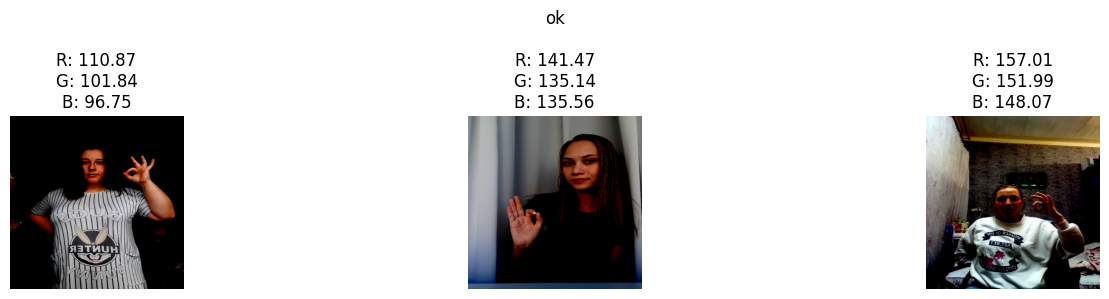

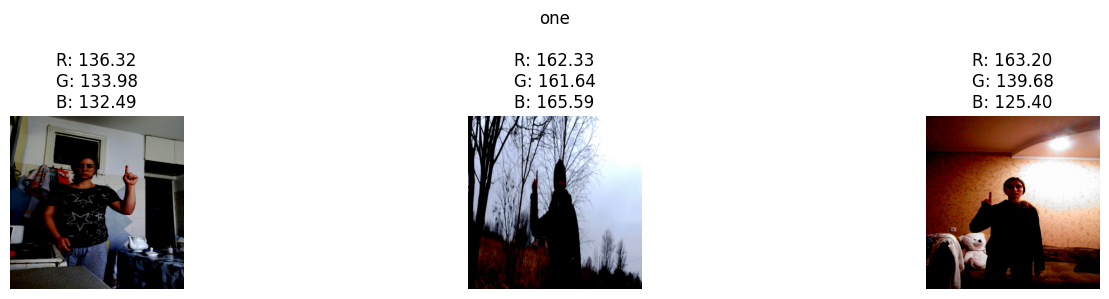

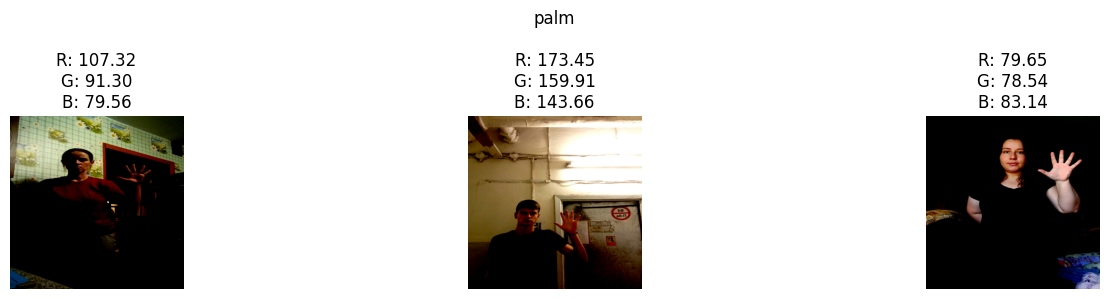

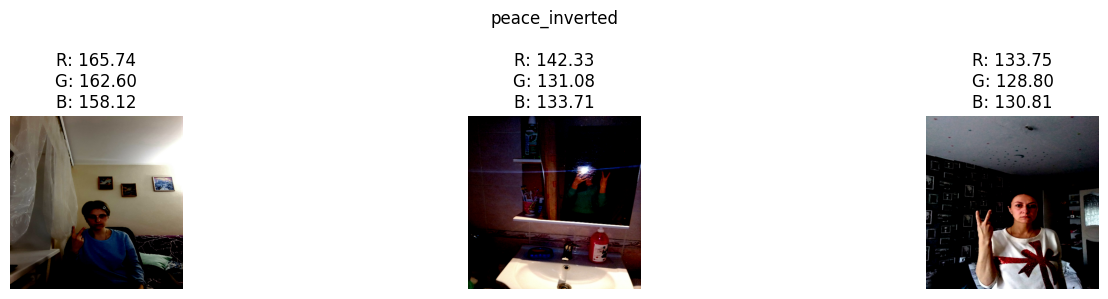

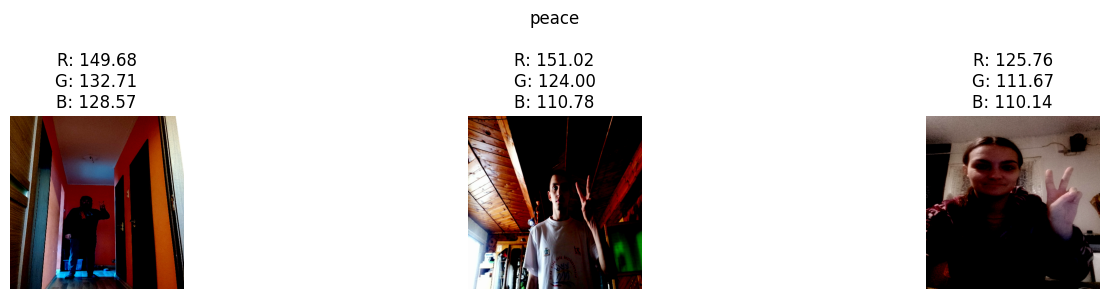

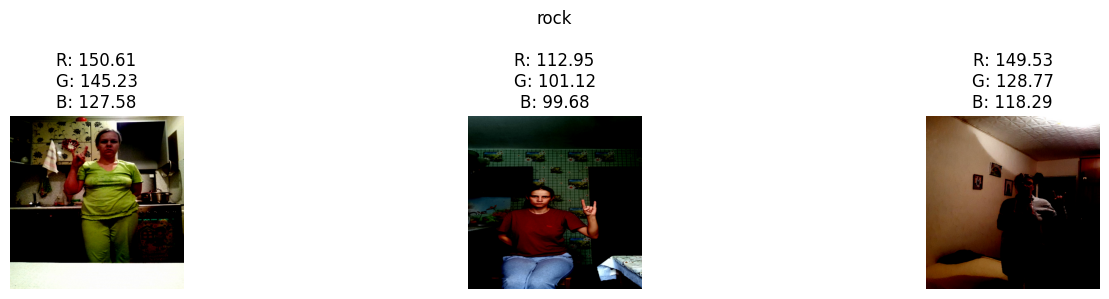

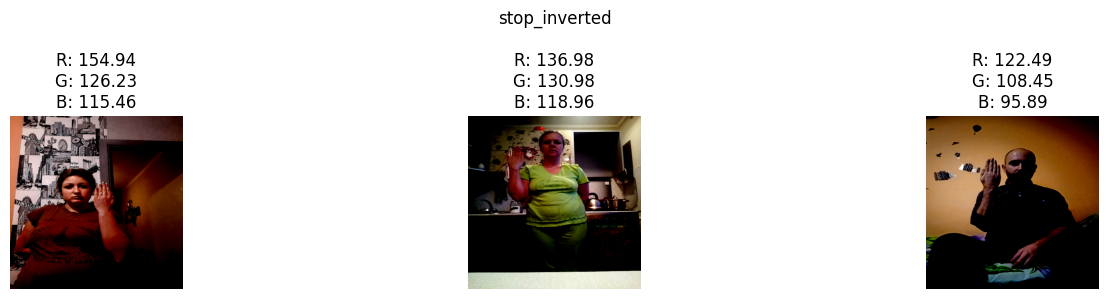

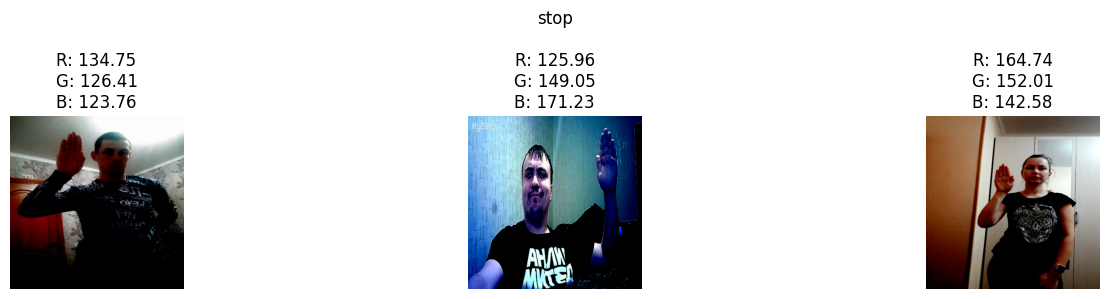

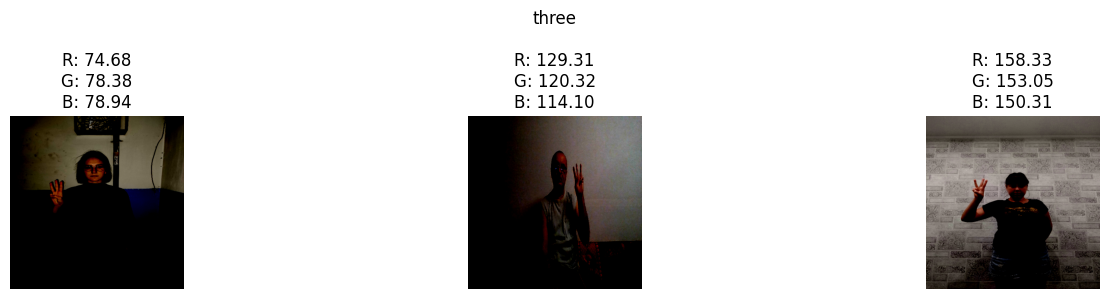

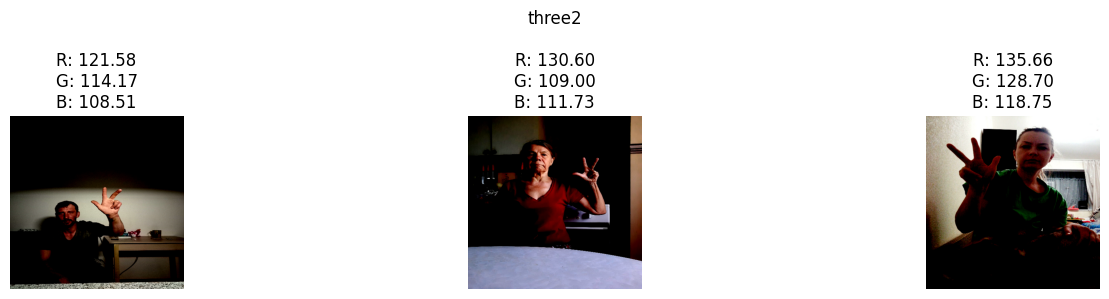

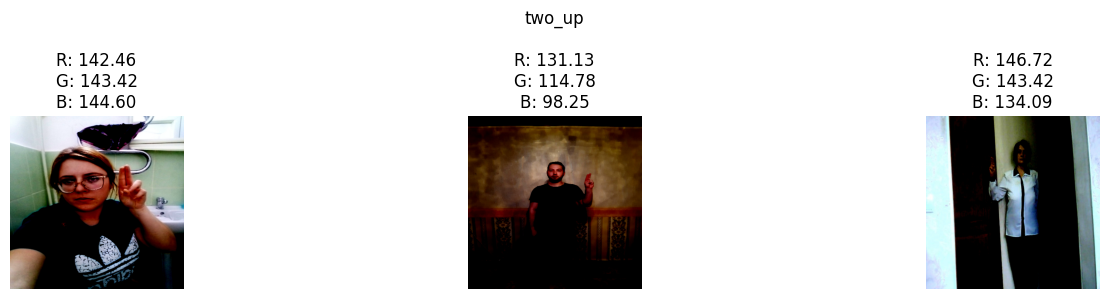

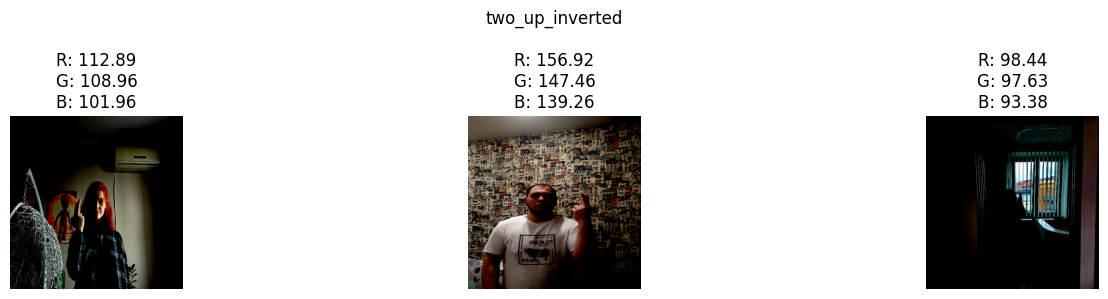

In [36]:
def display_sample_images_with_rgb(data_by_category, num_samples=3):
    for category, data in data_by_category.items():
        sample_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_images = [data[i] for i in sample_indices]

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        fig.suptitle(category)

        for ax, (img, _) in zip(axes, sample_images):
            avg_rgb = get_average_rgb(img)

            if img.dtype == np.float32 or img.dtype == np.float64:
                # Ensure float images are between 0 and 1
                img = np.clip(img, 0, 1)
            else:
                # Ensure integer images are between 0 and 255
                img = np.clip(img, 0, 255).astype(np.uint8)

            ax.imshow(img)
            ax.set_title(f"R: {avg_rgb[0]:.2f}\nG: {avg_rgb[1]:.2f}\nB: {avg_rgb[2]:.2f}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

display_sample_images_with_rgb(train_by_category)


Many of these images are very dark, or the picture was taken far away, making it difficult to make out the hand sign. For this reason, I increased the image sizes from 128 x 128 to 516 x 516 for more detail for the modeling.

Visualizing landmarks and bounding boxes

In [ ]:
def visualize_bbox_and_landmarks(image_path, bboxes, landmarks):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for bbox in bboxes:
        # Assuming bbox is [x_min, y_min, x_max, y_max]
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Draw landmarks
    for landmark in landmarks:
        # Assuming landmark is [x, y]
        cv2.circle(image, (landmark[0], landmark[1]), 2, (255, 0, 0), -1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

Data augmentation visualization to see if images are displayed as expected.

In [ ]:
# Define data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sample image
img = load_img(sample_image_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Visualize some augmented images
plt.figure(figsize=(12,12))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    plt.subplot(3, 3, i+1)
    plt.imshow(array_to_img(batch[0]))
    plt.axis('off')
    if i == 8:
        break
plt.show()


In [ ]:
all_pixel_values = []

for image_path in dataset_image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Using grayscale for simplicity
    pixel_values = image.reshape(-1)
    all_pixel_values.extend(pixel_values)

# Convert to numpy array
all_pixel_values = np.array(all_pixel_values)

# Calculate statistics
mean_pixel_value = np.mean(all_pixel_values)
median_pixel_value = np.median(all_pixel_values)
std_pixel_value = np.std(all_pixel_values)

print(f"Mean Pixel Value: {mean_pixel_value}")
print(f"Median Pixel Value: {median_pixel_value}")
print(f"Pixel Value Standard Deviation: {std_pixel_value}")


In [ ]:
# Create seperate sequence for "seperation of concerns". The Sequence class allows us to load data in chunks for memory efficiency.
class HagridGestureDataSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size=32, shuffle=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        X = [self.x[i] for i in batch_indexes]
        y = [self.y[i] for i in batch_indexes]

        X = np.array([img_to_array(img) / 255.0 for img in X])
        y = np_utils.to_categorical(y, len(class_names))

        return np.array(X), np.array(y)
